Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Jun 20 09:29:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/fruits-360.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

In [ ]:
# dimensions of our images.
img_width, img_height = 224, 224 # we set the img_width and img_height according to the pretrained models we are
# going to use. The input size for ResNet-50 is 224 by 224 by 3.

train_data_dir = '/content/fruits-360/Training'
validation_data_dir = '/content/fruits-360/Test'
nb_train_samples = 31688
nb_validation_samples = 10657
batch_size = 16

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=bda76caf3d9cd56665115bdd9e6225cbed095c62ea240945c33791ea882166cc
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet


In [ ]:
from keras.applications.resnet import ResNet50  
#import inception with pre-trained weights. do not include fully #connected layers
basemodel = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = basemodel.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(131, activation='softmax')(x)
# create the full network so we can train on it
model = Model(inputs=basemodel.input, outputs=predictions)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),metrics=['accuracy'])

In [9]:
history_pretrained = model.fit(train_generator,epochs=10, shuffle = True, verbose = 1, validation_data = validation_generator)

Epoch 1/10
4231/4231 [==============================] - 1047s 234ms/step - loss: 2.4952 - accuracy: 0.5437 - val_loss: 0.1074 - val_accuracy: 0.9769
Epoch 2/10
4231/4231 [==============================] - 973s 230ms/step - loss: 0.0944 - accuracy: 0.9909 - val_loss: 0.0688 - val_accuracy: 0.9836
Epoch 3/10
4231/4231 [==============================] - 959s 227ms/step - loss: 0.0388 - accuracy: 0.9968 - val_loss: 0.0476 - val_accuracy: 0.9865
Epoch 4/10
4231/4231 [==============================] - 957s 226ms/step - loss: 0.0227 - accuracy: 0.9984 - val_loss: 0.0446 - val_accuracy: 0.9888
Epoch 5/10
4231/4231 [==============================] - 962s 227ms/step - loss: 0.0166 - accuracy: 0.9989 - val_loss: 0.0379 - val_accuracy: 0.9899
Epoch 6/10
4231/4231 [==============================] - 955s 226ms/step - loss: 0.0129 - accuracy: 0.9991 - val_loss: 0.0370 - val_accuracy: 0.9902
Epoch 7/10
4231/4231 [==============================] - 950s 224ms/step - loss: 0.0104 - accuracy: 0.9992 - val

In [10]:
model.evaluate(validation_generator,verbose=2)

1418/1418 - 77s - loss: 0.0318 - accuracy: 0.9915


[0.0318264439702034, 0.9915373921394348]

In [11]:
model.save('/content/fruits-360/resnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
model=tf.keras.models.load_model('/content/fruits-360/resnet.h5')
batch_size = 16
num_of_test_samples=22688
# Y_pred=model.predict(validation_generator)
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = model.predict_generator(validation_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
cm=confusion_matrix(validation_generator.classes, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1418/1418 [==============================] - 73s 51ms/step


In [13]:
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
P=precision_score(validation_generator.classes, y_pred, average="macro")  
print(P*100)
from sklearn.metrics import accuracy_score
A=accuracy_score(validation_generator.classes, y_pred)
print(A*100)
from sklearn.metrics import f1_score
f1=f1_score(validation_generator.classes, y_pred,average='micro')
print(f1*100)

0.773524201744082
0.8065937940761636
0.8065937940761636


In [14]:
print(cm)

[[3 0 0 ... 1 2 0]
 [0 2 1 ... 0 0 2]
 [2 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 1 0]
 [3 2 0 ... 5 2 2]
 [2 0 1 ... 0 0 1]]


In [17]:
cm

array([[3, 0, 0, ..., 1, 2, 0],
       [0, 2, 1, ..., 0, 0, 2],
       [2, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [3, 2, 0, ..., 5, 2, 2],
       [2, 0, 1, ..., 0, 0, 1]])

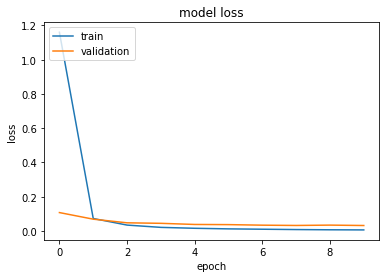

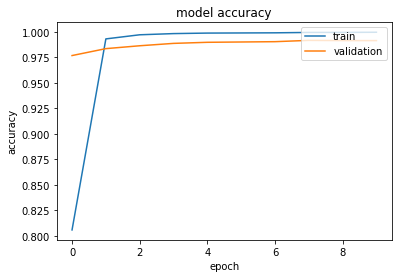

In [15]:
import matplotlib.pyplot as plt
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(validation_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.02      0.02      0.02       164
           1       0.01      0.01      0.01       148
           2       0.00      0.00      0.00       160
           3       0.02      0.02      0.02       164
           4       0.03      0.03      0.03       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.01      0.01      0.01       164
           8       0.01      0.01      0.01       164
           9       0.01      0.01      0.01       144
          10       0.01      0.01      0.01       166
          11       0.01      0.01      0.01       164
          12       0.01      0.01      0.01       219
          13       0.01      0.01      0.01       164
          14       0.01      0.01      0.01       143
          15       0.00      0.00      0.00       166
          16       0.01      0.01      0.01       166
          17       0.00    

# New Section